# **Klasifikasi Gambar Penyakit Pneumonia**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan infeksi paru-paru seseorang menggunakan gambar medis.

## **Sumber Dataset**
https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

# **Import Libraries**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


# **Data Loading**

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2) (1).json


{'kaggle (2) (1).json': b'{"username":"angelmetanosaa","key":"ddd6f643d4c26b0e05f991898018e0ca"}'}

In [ ]:
!rm -rf chest_xray/

In [ ]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

## **Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [ ]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

# Direktori baru untuk dataset gabungan
combined_dir = "chest_xray/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## **Plot gambar sampel untuk semua kelas**

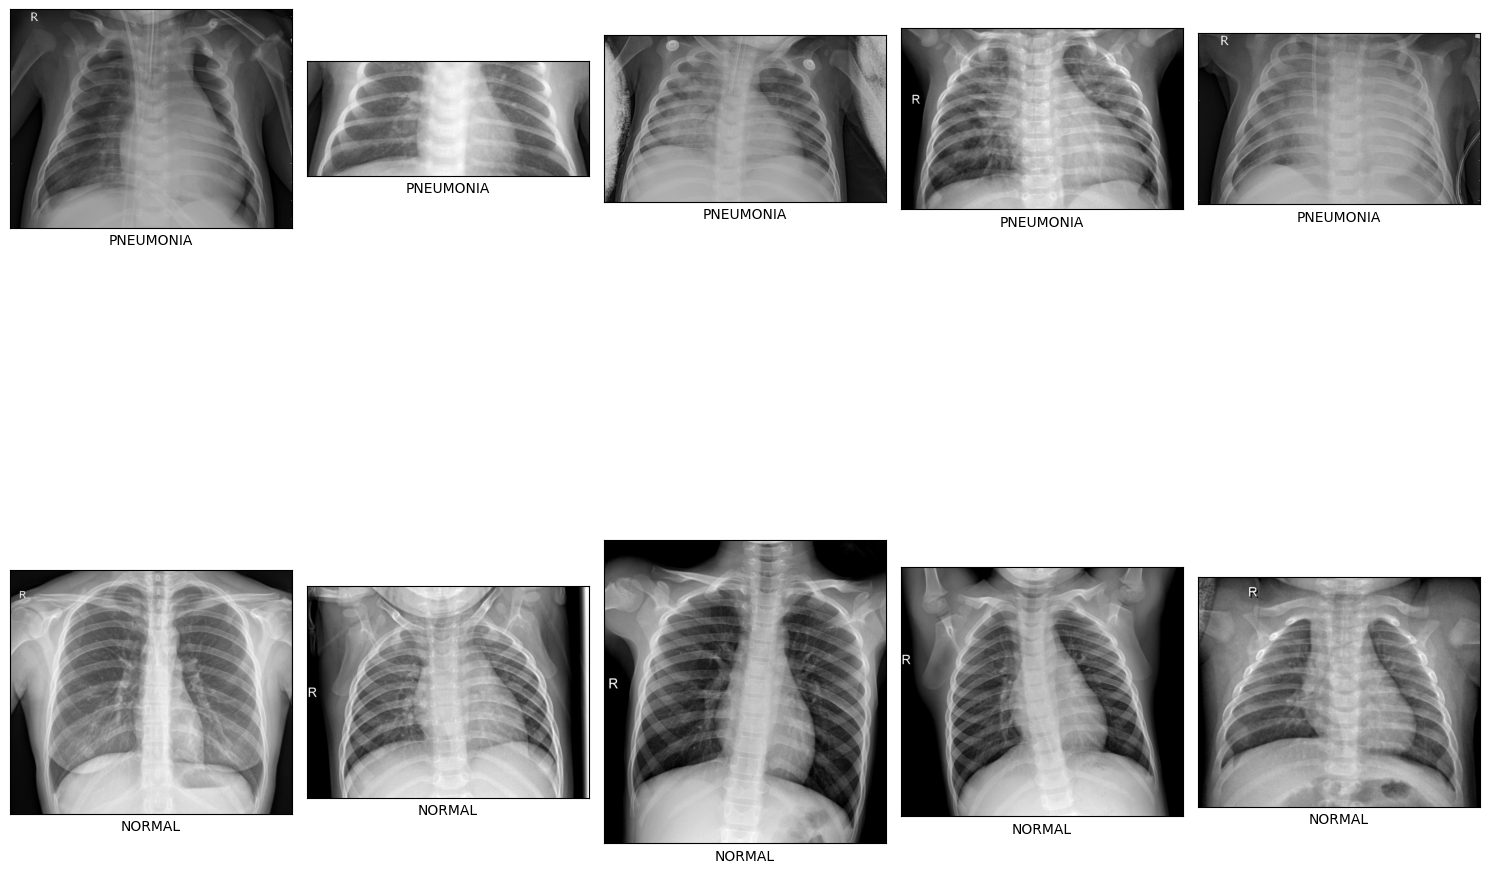

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "chest_xray/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot distribusi gambar di seluruh kelas**

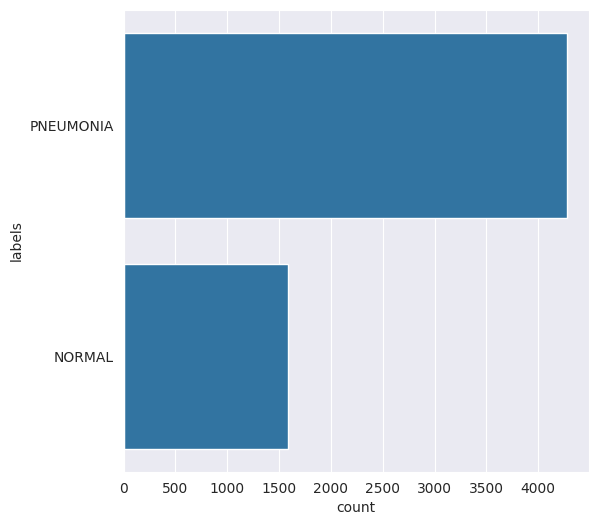

In [ ]:
# Define source path
lung_path = "chest_xray/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.random_blur(img, (3, 3))  # Ukuran kernel blur bisa disesuaikan
    return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "chest_xray/dataset/NORMAL"  # Path for the original image
augmented_path = "chest_xray/dataset/NORMAL_augmented"  # Path to put the augmented image
images = []  # To save images that have been preprocessed from the folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

could not read the chest_xray/dataset/NORMAL/NORMAL-5802954-0001.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-3873301-0002.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-1602427-0001.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-5578360-0001.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-8347029-0001.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-4663193-0001.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NORMAL-1444388-0002.jpeg : 'images' must have either 3 or 4 dimensions. hence skipping it.
could not read the chest_xray/dataset/NORMAL/NOR

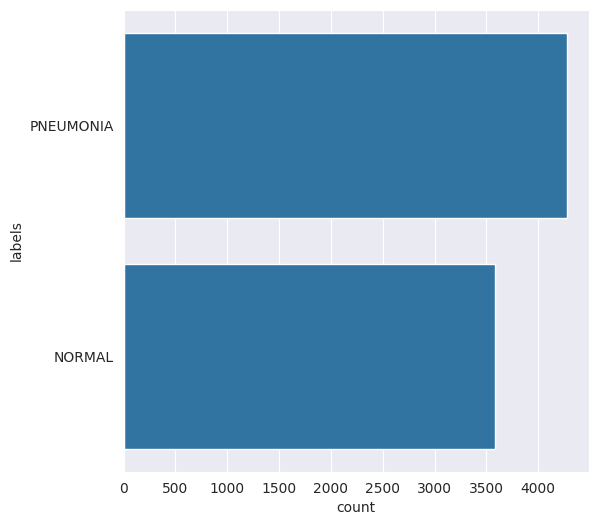

In [ ]:
# Define source path
lung_path = "chest_xray/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting : Training and Testing**

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
NORMAL       3583
PNEUMONIA    4273
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 6284
test size 1572


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   NORMAL        733
       PNEUMONIA     839
train  NORMAL       2850
       PNEUMONIA    3434
dtype: int64 


                                                   path     labels    set
724   chest_xray/dataset/NORMAL/augmented_image_857.jpg     NORMAL  train
2970  chest_xray/dataset/PNEUMONIA/BACTERIA-1614511-...  PNEUMONIA  train
2656  chest_xray/dataset/NORMAL/augmented_image_282.jpg     NORMAL  train
6369  chest_xray/dataset/NORMAL/NORMAL-7233925-0001....     NORMAL   test
1422  chest_xray/dataset/PNEUMONIA/VIRUS-2528951-000...  PNEUMONIA  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In TensorFlow you can do this through the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to do:
- Configure the random transformation and normalization operations to be performed on the image data during training
- Instantiate generator of augmented image sets (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. This generator can then be used with `tf.keras` model methods which accept generator data as input, `fit`, `evaluate` and `predict`

Prepare the training and validation data, to begin with using `.flow_from_directory()` which generates image datasets and their labels directly in their respective folders by setting the `WIDTH` and `HEIGHT` size, predefined `BATCH SIZE` size and mode its class. Here we use `"binary"` class mode because the number of classes used is 2.

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_normal = os.path.join(TRAIN_DIR + '/NORMAL')
train_pneumonia = os.path.join(TRAIN_DIR + '/PNEUMONIA')
test_normal = os.path.join(TEST_DIR + '/NORMAL')
test_pneumonia = os.path.join(TEST_DIR + '/PNEUMONIA')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))

Total number of normal images in training set:  2850
Total number of pneumonic images in training set:  3434
Total number of normal images in test set:  733
Total number of pneumonic images in test set:  839


In [ ]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 5028 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.
Found 1572 images belonging to 2 classes.


# **Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):**

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 13.6 µs
Epoch 1/30
158/158 [==============================] - 38s 191ms/step - loss: 0.6196 - accuracy: 0.8270 - val_loss: 4.9154 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 31s 196ms/step - loss: 0.1940 - accuracy: 0.9284 - val_loss: 8.6049 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 30s 190ms/step - loss: 0.1494 - accuracy: 0.9519 - val_loss: 0.4947 - val_accuracy: 0.8694
Epoch 4/30
158/158 [==============================] - 30s 191ms/step - loss: 0.1189 - accuracy: 0.9618 - val_loss: 0.5166 - val_accuracy: 0.7938
Epoch 5/30
158/158 [==============================] - 30s 189ms/step - loss: 0.0967 - accuracy: 0.9716 - val_loss: 0.1300 - val_accuracy: 0.9618
Epoch 6/30
158/158 [==============================] - 30s 192ms/step - loss: 0.0896 - accuracy: 0.9737 - val_loss: 0.3351 - val_accuracy: 0.9156
Epoch 7/30
158/158 [==============================] - 31s 193ms/st

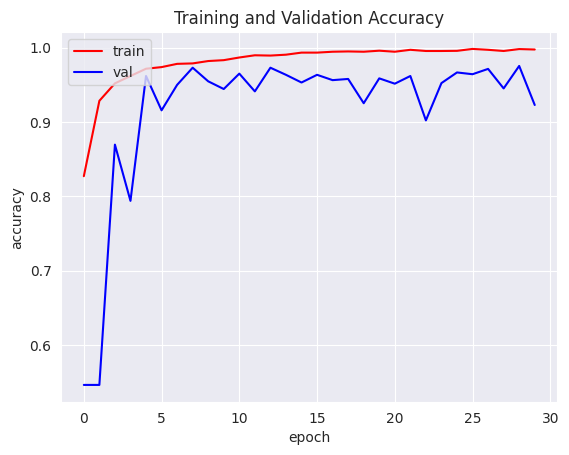

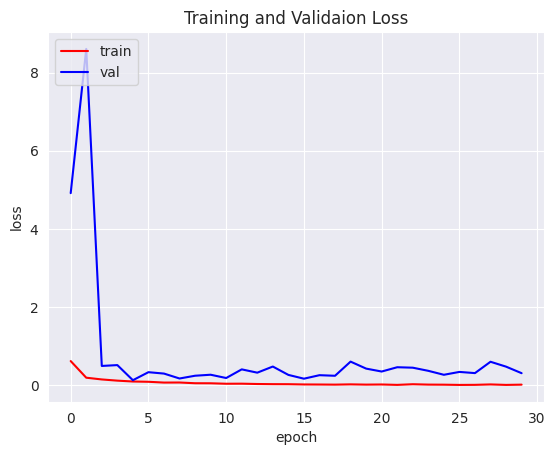

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.8711    0.9864    0.9251       733
   Pneumonia     0.9865    0.8725    0.9260       839

    accuracy                         0.9256      1572
   macro avg     0.9288    0.9294    0.9256      1572
weighted avg     0.9327    0.9256    0.9256      1572



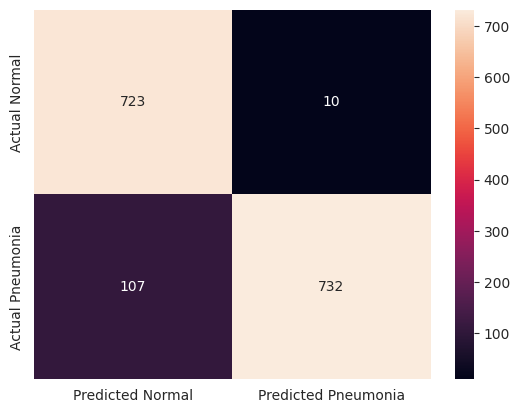

In [ ]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer:**

1. Add 3 convolutional layers with each layer have 64 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_2 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (4, 4),padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_2.add(Conv2D(64, (7, 7), padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D((2, 2)))

# Flatten layer
model_2.add(Flatten())
# 1nd Dense Layer
model_2.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_2.add(Dropout(0.5))
# 2nd Dense Layer
model_2.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_2.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_2.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 64)      640       
                                                                 
 batch_normalization_3 (Bat  (None, 150, 150, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        65600     
                                                                 
 batch_normalization_4 (Bat  (None, 75, 75, 64)        256       
 chNormalization)                                                
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_2 = model_2.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Epoch 1/30
158/158 [==============================] - 36s 196ms/step - loss: 1.0681 - accuracy: 0.7969 - val_loss: 9.9411 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 31s 196ms/step - loss: 0.3268 - accuracy: 0.8956 - val_loss: 11.2858 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 32s 204ms/step - loss: 0.2375 - accuracy: 0.9252 - val_loss: 23.1404 - val_accuracy: 0.5462
Epoch 4/30
158/158 [==============================] - 31s 198ms/step - loss: 0.1978 - accuracy: 0.9437 - val_loss: 1.2957 - val_accuracy: 0.5462
Epoch 5/30
158/158 [==============================] - 31s 195ms/step - loss: 0.1666 - accuracy: 0.9419 - val_loss: 0.2003 - val_accuracy: 0.9514
Epoch 6/30
158/158 [==============================] - 31s 197ms/step - loss: 0.1467 - accuracy: 0.9535 - val_loss: 0.2376 - val_accuracy: 0.9395
Epoch 7/30
158/158 [==============================] - 32s 202ms/

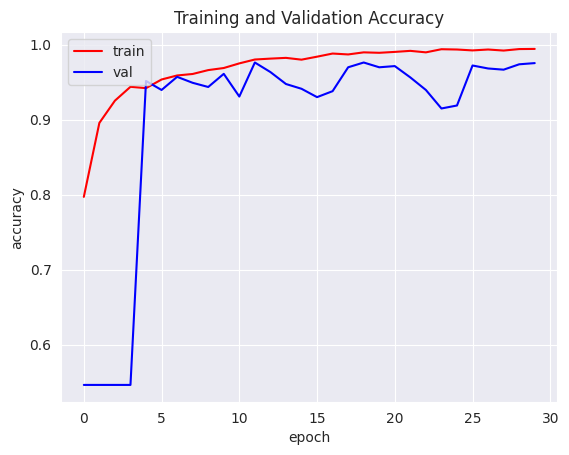

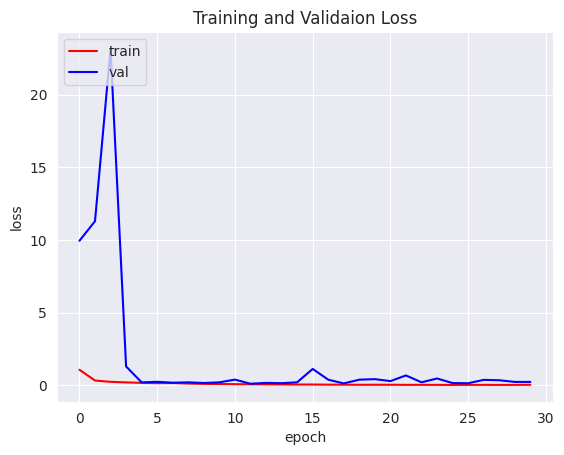

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9528    0.9905    0.9712       733
   Pneumonia     0.9914    0.9571    0.9739       839

    accuracy                         0.9726      1572
   macro avg     0.9721    0.9738    0.9726      1572
weighted avg     0.9734    0.9726    0.9727      1572



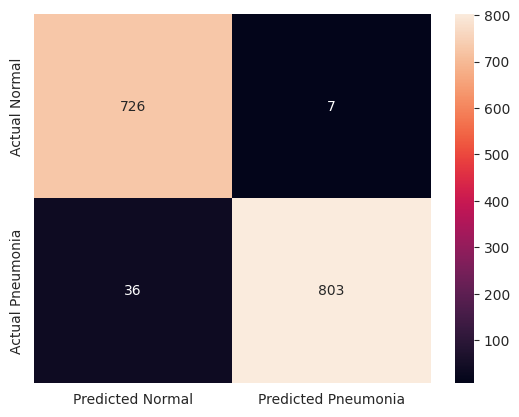

In [ ]:
test_generator.reset()

preds_2 = model_2.predict(test_generator,verbose=0)
preds_2 = preds_2.copy()
preds_2[preds_2 <= 0.5] = 0
preds_2[preds_2 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_2, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_2,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 3 - CNN Architecture Using 128 Neurons in Conv Layer:**

1. Add 3 convolutional layers with each layer have 128 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good



In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_3 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (4, 4),padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))

# Flatten layer
model_3.add(Flatten())
# 1nd Dense Layer
model_3.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_3.add(Dropout(0.5))
# 2nd Dense Layer
model_3.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_3.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_3.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 150, 150, 128)     1280      
                                                                 
 batch_normalization_6 (Bat  (None, 150, 150, 128)     512       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 128)       262272    
                                                                 
 batch_normalization_7 (Bat  (None, 75, 75, 128)       512       
 chNormalization)                                                
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_3 = model_3.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
Epoch 1/30
158/158 [==============================] - 42s 226ms/step - loss: 2.0498 - accuracy: 0.7572 - val_loss: 14.4781 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 34s 217ms/step - loss: 0.5106 - accuracy: 0.8375 - val_loss: 17.5401 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 34s 214ms/step - loss: 0.3597 - accuracy: 0.8926 - val_loss: 15.2471 - val_accuracy: 0.5470
Epoch 4/30
158/158 [==============================] - 34s 218ms/step - loss: 0.2589 - accuracy: 0.9055 - val_loss: 1.2554 - val_accuracy: 0.6154
Epoch 5/30
158/158 [==============================] - 35s 219ms/step - loss: 0.1853 - accuracy: 0.9354 - val_loss: 0.2580 - val_accuracy: 0.9260
Epoch 6/30
158/158 [==============================] - 36s 226ms/step - loss: 0.1699 - accuracy: 0.9465 - val_loss: 0.3037 - val_accuracy: 0.9498
Epoch 7/30
158/158 [==============================] - 35s 220ms

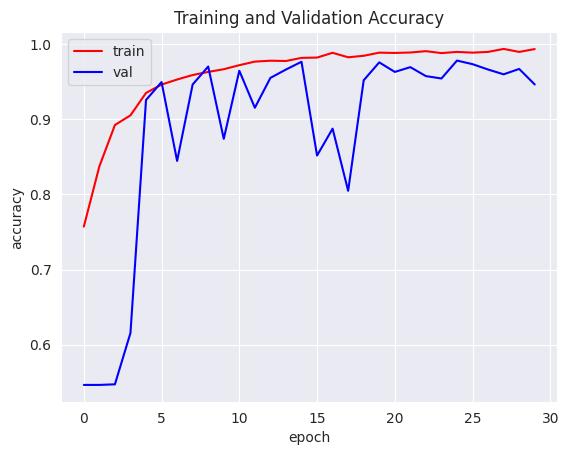

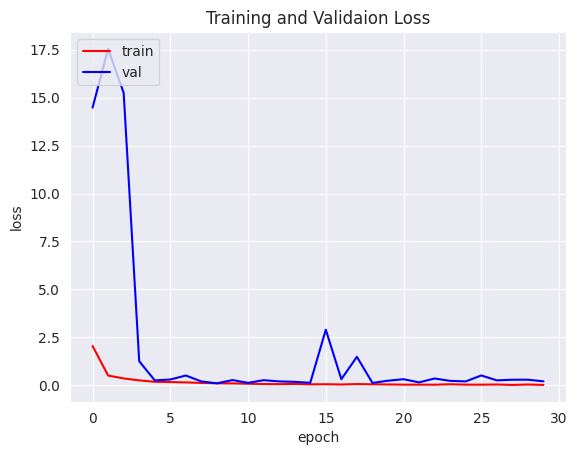

In [ ]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9714    0.9263    0.9483       733
   Pneumonia     0.9381    0.9762    0.9568       839

    accuracy                         0.9529      1572
   macro avg     0.9548    0.9512    0.9525      1572
weighted avg     0.9536    0.9529    0.9528      1572



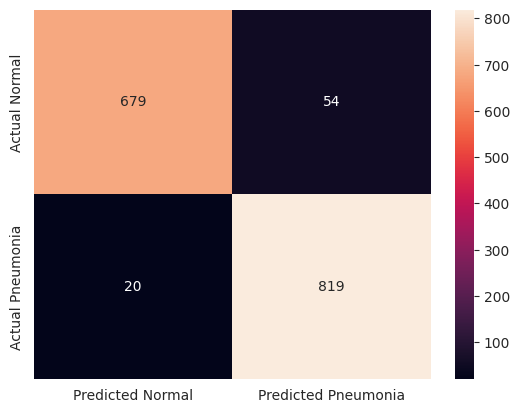

In [ ]:
test_generator.reset()

preds_3 = model_3.predict(test_generator,verbose=0)
preds_3 = preds_3.copy()
preds_3[preds_3 <= 0.5] = 0
preds_3[preds_3 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_3, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_3,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 4 - CNN Architecture (Using Learning Rate 0.001):**

From the evaluation results of the two models, we can consider some key performance metrics such as precision, recall, and f1-score to determine the best model based on specific needs.

Model 1:

Normal Precision: 0.9941 <br>
Normal Recall: 0.9479 <br>
F1-score Normal: 0.9704 <br>
Precision Pneumonia: 0.9587 <br>
Recall Pneumonia: 0.9954 <br>
F1-score Pneumonia: 0.9767 <br>
Accuracy: 0.9739


Model 2:

Precision Normal: 0.9691 <br>
Recall Normal: 0.9732 <br>
F1-score Normal: 0.9712 <br>
Precision Pneumonia: 0.9779 <br>
Recall Pneumonia: 0.9745 <br>
F1-score Pneumonia: 0.9762 <br>
Accuracy: 0.9739 <br>
Both models have the same accuracy (0.9739), but there are differences in the precision, recall, and f1-score metrics for the Normal and Pneumonia classes.

<br>

Considerations:

If we focus on the Normal class:

*   Model 1 has a higher precision (0.9941 vs 0.9691).
*   Model 1 has a slightly lower recall (0.9479 vs 0.9732).
*   The F1-score for the Normal class is slightly higher in Model 1 (0.9704 vs 0.9712).

If we focus on the Pneumonia class:
*   Model 1 has a higher recall (0.9954 vs 0.9745).
*   Precision for the Pneumonia class is almost the same between the two models.
*   The F1-score for the Pneumonia class is slightly higher in Model 1 (0.9767 vs 0.9762).

<br>

Conclusion:

*   If the main priority is to optimize Pneumonia detection (minority class), Model 1 may be more desirable as it has a higher recall for the Pneumonia class.
*   If the main concern is to maintain Normal classification precision, Model 1 also gives better results in terms of precision for the Normal class.

<br>

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer with learning rate 0.001
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_4 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_4.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

# Flatten layer
model_4.add(Flatten())
# 1nd Dense Layer
model_4.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_4.add(Dropout(0.5))
# 2nd Dense Layer
model_4.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_4.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_4.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_9 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_10 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_4 = model_4.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Epoch 1/30
158/158 [==============================] - 33s 188ms/step - loss: 0.7193 - accuracy: 0.7882 - val_loss: 6.4083 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 29s 185ms/step - loss: 0.2562 - accuracy: 0.9224 - val_loss: 9.1533 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 30s 188ms/step - loss: 0.2003 - accuracy: 0.9413 - val_loss: 13.2601 - val_accuracy: 0.5462
Epoch 4/30
158/158 [==============================] - 32s 205ms/step - loss: 0.1460 - accuracy: 0.9556 - val_loss: 0.3670 - val_accuracy: 0.8416
Epoch 5/30
158/158 [==============================] - 30s 193ms/step - loss: 0.1282 - accuracy: 0.9610 - val_loss: 0.2426 - val_accuracy: 0.9188
Epoch 6/30
158/158 [==============================] - 29s 184ms/step - loss: 0.1013 - accuracy: 0.9672 - val_loss: 0.1591 - val_accuracy: 0.9514
Epoch 7/30
158/158 [==============================] - 29s 186ms/s

In [ ]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
test_generator.reset()

preds_4 = model_4.predict(test_generator,verbose=0)
preds_4 = preds_4.copy()
preds_4[preds_4 <= 0.5] = 0
preds_4[preds_4 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_4, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_4,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 5 - CNN Architecture (Using Learning Rate 0.0001):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer with learning rate 0.0001
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_5 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_5.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D((2, 2)))

# Flatten layer
model_5.add(Flatten())
# 1nd Dense Layer
model_5.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_5.add(Dropout(0.5))
# 2nd Dense Layer
model_5.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_5.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_5.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_5.summary())

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_5 = model_5.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Epoch 1/30
158/158 [==============================] - 31s 185ms/step - loss: 0.3180 - accuracy: 0.8725 - val_loss: 1.7403 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 29s 186ms/step - loss: 0.1735 - accuracy: 0.9399 - val_loss: 2.2906 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 31s 197ms/step - loss: 0.1249 - accuracy: 0.9562 - val_loss: 0.5468 - val_accuracy: 0.8089
Epoch 4/30
158/158 [==============================] - 29s 185ms/step - loss: 0.1065 - accuracy: 0.9622 - val_loss: 0.1169 - val_accuracy: 0.9586
Epoch 5/30
158/158 [==============================] - 30s 187ms/step - loss: 0.0878 - accuracy: 0.9700 - val_loss: 0.1108 - val_accuracy: 0.9682
Epoch 6/30
158/158 [==============================] - 30s 189ms/step - loss: 0.0880 - accuracy: 0.9702 - val_loss: 0.1926 - val_accuracy: 0.9490
Epoch 7/30
158/158 [==============================] - 29s 184ms/st

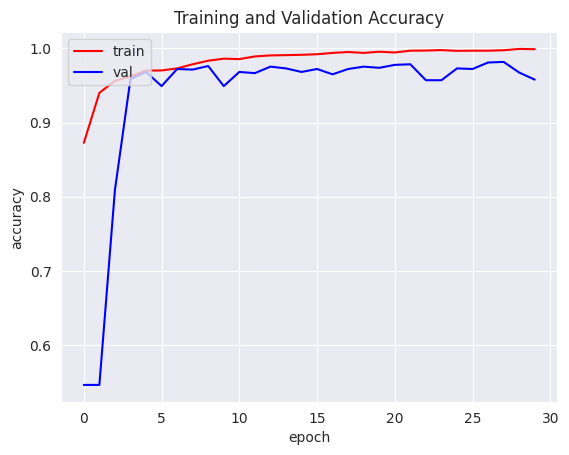

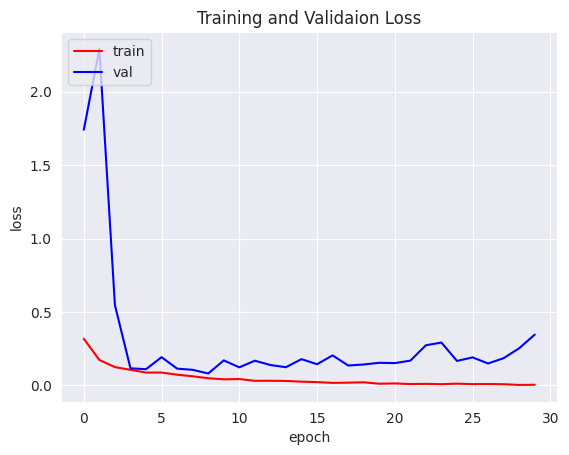

In [ ]:
acc = history_5.history['accuracy']
val_acc = history_5.history['val_accuracy']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9831    0.9536    0.9681       733
   Pneumonia     0.9605    0.9857    0.9729       839

    accuracy                         0.9707      1572
   macro avg     0.9718    0.9697    0.9705      1572
weighted avg     0.9711    0.9707    0.9707      1572



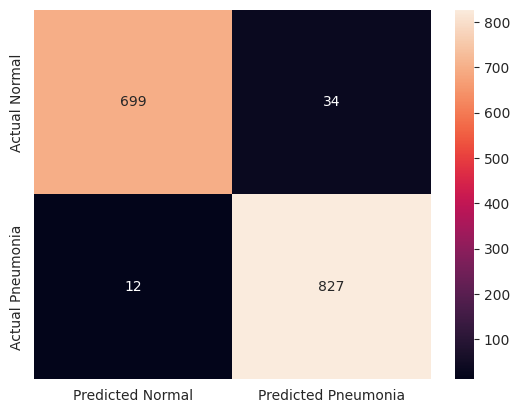

In [ ]:
test_generator.reset()

preds_5 = model_5.predict(test_generator,verbose=0)
preds_5 = preds_5.copy()
preds_5[preds_5 <= 0.5] = 0
preds_5[preds_5 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_5, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_5,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 6 - CNN Architecture (Using Learning Rate 0.00001):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take rmsprop as an optimizer with learning rate 0.00001
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_6 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_6.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_6.add(BatchNormalization())
model_6.add(MaxPooling2D((2, 2)))

# Flatten layer
model_6.add(Flatten())
# 1nd Dense Layer
model_6.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_6.add(Dropout(0.5))
# 2nd Dense Layer
model_6.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_6.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_6.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_6.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_15 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_16 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}
xszd

%time

# Fitting / training model
history_6 = model_6.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/30
158/158 [==============================] - 33s 197ms/step - loss: 0.5768 - accuracy: 0.7315 - val_loss: 0.8009 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 30s 191ms/step - loss: 0.3267 - accuracy: 0.8538 - val_loss: 1.1896 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 29s 184ms/step - loss: 0.2568 - accuracy: 0.8952 - val_loss: 0.6598 - val_accuracy: 0.6226
Epoch 4/30
158/158 [==============================] - 29s 186ms/step - loss: 0.2223 - accuracy: 0.9159 - val_loss: 0.2842 - val_accuracy: 0.8678
Epoch 5/30
158/158 [==============================] - 32s 201ms/step - loss: 0.1824 - accuracy: 0.9268 - val_loss: 0.1675 - val_accuracy: 0.9363
Epoch 6/30
158/158 [==============================] - 29s 185ms/step - loss: 0.1675 - accuracy: 0.9332 - val_loss: 0.1372 - val_accuracy: 0.9498
Epoch 7/30
158/158 [==============================] - 30s 189ms/st

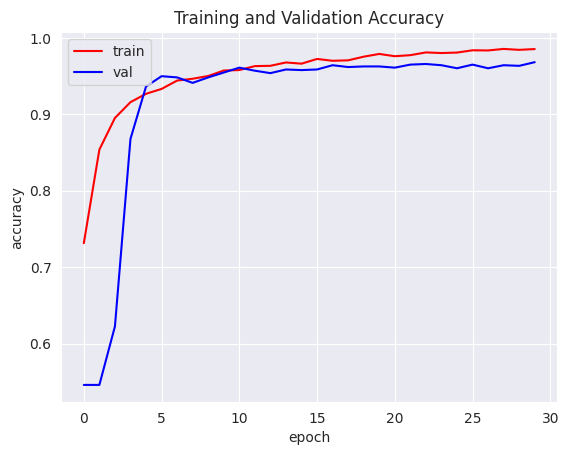

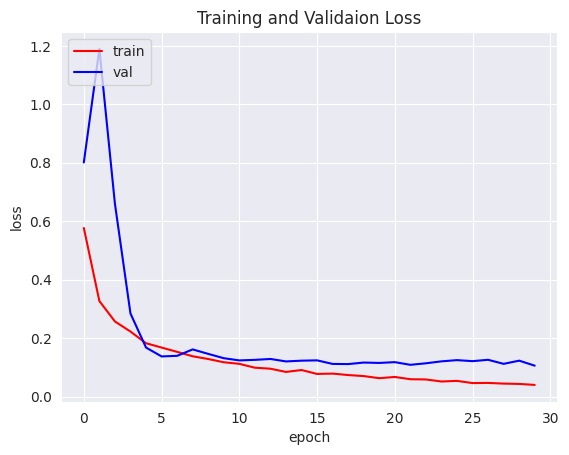

In [ ]:
acc = history_6.history['accuracy']
val_acc = history_6.history['val_accuracy']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9635    0.9727    0.9681       733
   Pneumonia     0.9760    0.9678    0.9719       839

    accuracy                         0.9701      1572
   macro avg     0.9697    0.9703    0.9700      1572
weighted avg     0.9702    0.9701    0.9701      1572



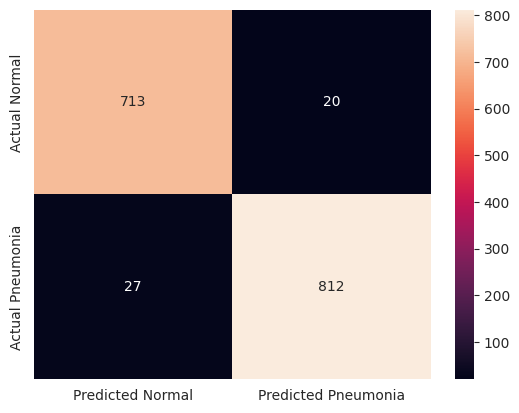

In [ ]:
test_generator.reset()

preds_6 = model_6.predict(test_generator,verbose=0)
preds_6 = preds_6.copy()
preds_6[preds_6 <= 0.5] = 0
preds_6[preds_6 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_6, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_6,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 7 - CNN Architecture (Using Adam as Optimizer):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take Adam as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_7 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_7.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D((2, 2)))

# Flatten layer
model_7.add(Flatten())
# 1nd Dense Layer
model_7.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_7.add(Dropout(0.5))
# 2nd Dense Layer
model_7.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_7.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_7.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_7.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_18 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_19 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_7 = model_7.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/30
158/158 [==============================] - 34s 196ms/step - loss: 0.4343 - accuracy: 0.8492 - val_loss: 5.0895 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 30s 192ms/step - loss: 0.1982 - accuracy: 0.9304 - val_loss: 1.4459 - val_accuracy: 0.6608
Epoch 3/30
158/158 [==============================] - 29s 183ms/step - loss: 0.1608 - accuracy: 0.9459 - val_loss: 0.1291 - val_accuracy: 0.9570
Epoch 4/30
158/158 [==============================] - 29s 183ms/step - loss: 0.1246 - accuracy: 0.9515 - val_loss: 0.2334 - val_accuracy: 0.9307
Epoch 5/30
158/158 [==============================] - 30s 193ms/step - loss: 0.1336 - accuracy: 0.9525 - val_loss: 0.3401 - val_accuracy: 0.8527
Epoch 6/30
158/158 [==============================] - 30s 190ms/step - loss: 0.1304 - accuracy: 0.9560 - val_loss: 0.8696 - val_accuracy: 0.7627
Epoch 7/30
158/158 [==============================] - 29s 183ms/st

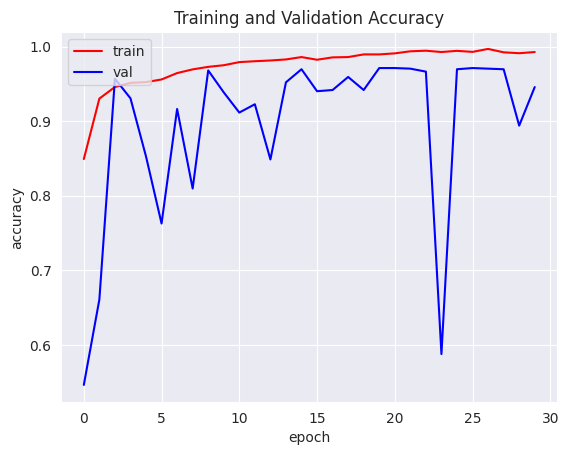

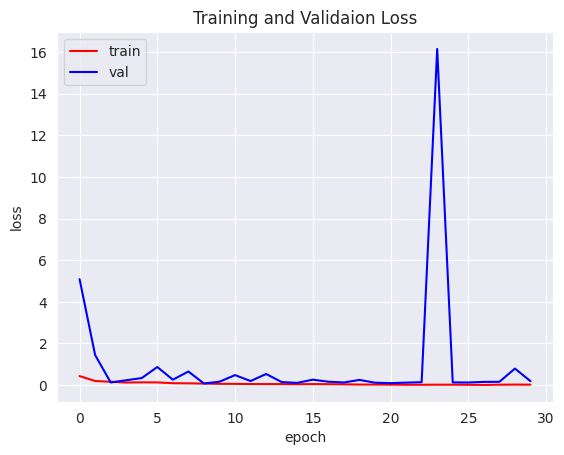

In [ ]:
acc = history_7.history['accuracy']
val_acc = history_7.history['val_accuracy']
loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9860    0.9577    0.9716       733
   Pneumonia     0.9640    0.9881    0.9759       839

    accuracy                         0.9739      1572
   macro avg     0.9750    0.9729    0.9737      1572
weighted avg     0.9742    0.9739    0.9739      1572



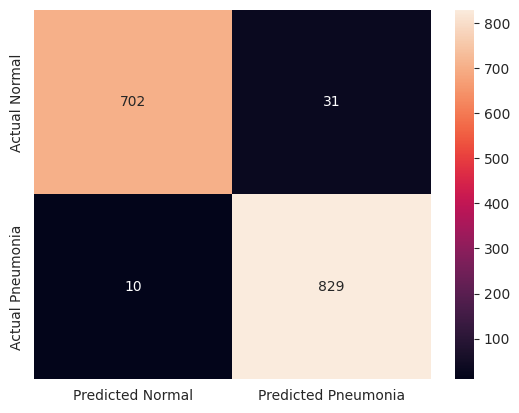

In [ ]:
test_generator.reset()

preds_7 = model_7.predict(test_generator,verbose=0)
preds_7 = preds_7.copy()
preds_7[preds_7 <= 0.5] = 0
preds_7[preds_7 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_7, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_7,target_names =['Normal','Pneumonia'], digits=4))

# **Model Exp 8 - CNN Architecture (Using SGD as Optimizer):**

1. Add 3 convolutional layers with each layer have 32 neurons, first filter 3x3, second filter 4x4, third filter 7x7, max pool layers 2x2, and batch normalization layers  
2. Add flatten layer, dense layers, and dropout layers
3. Use Relu as an activation function
4. Take the loss function as binary cross-entropy
5. Take SGD as an optimizer
6. Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
7. Try with 30 numbers epoch
8. Train the model using a generator and test the accuracy of the test data at every epoch
9. Plot the training and validation accuracy, and the loss
10. Observe the precision, recall, the F1-score for all classes and determine if the model’s classes are good


In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_8 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_8.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D((2, 2)))

# Flatten layer
model_8.add(Flatten())
# 1nd Dense Layer
model_8.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_8.add(Dropout(0.5))
# 2nd Dense Layer
model_8.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_8.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_8.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_8.compile(optimizer=tf.keras.optimizers.SGD(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_8.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_21 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_22 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_8 = model_8.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/30
158/158 [==============================] - 32s 187ms/step - loss: 0.3662 - accuracy: 0.8453 - val_loss: 1.5902 - val_accuracy: 0.5462
Epoch 2/30
158/158 [==============================] - 29s 184ms/step - loss: 0.1750 - accuracy: 0.9296 - val_loss: 2.3441 - val_accuracy: 0.5462
Epoch 3/30
158/158 [==============================] - 30s 189ms/step - loss: 0.1388 - accuracy: 0.9477 - val_loss: 0.3847 - val_accuracy: 0.8519
Epoch 4/30
158/158 [==============================] - 29s 182ms/step - loss: 0.1065 - accuracy: 0.9572 - val_loss: 0.1517 - val_accuracy: 0.9546
Epoch 5/30
158/158 [==============================] - 30s 192ms/step - loss: 0.1047 - accuracy: 0.9634 - val_loss: 0.1002 - val_accuracy: 0.9674
Epoch 6/30
158/158 [==============================] - 29s 183ms/step - loss: 0.0948 - accuracy: 0.9674 - val_loss: 0.1340 - val_accuracy: 0.9514
Epoch 7/30
158/158 [==============================] - 29s 183ms/st

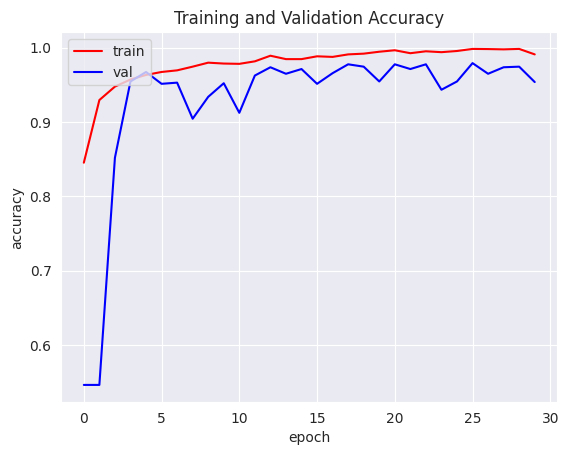

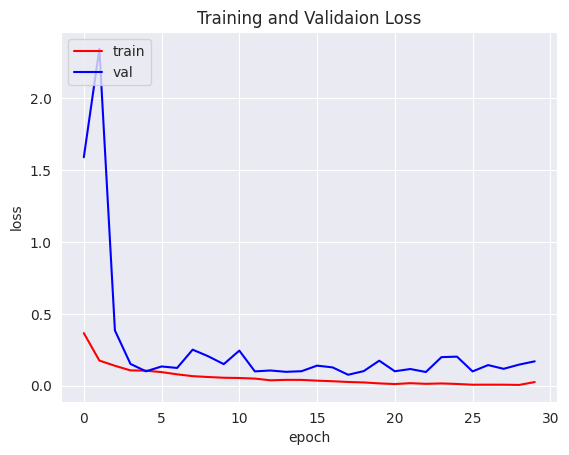

In [ ]:
acc = history_8.history['accuracy']
val_acc = history_8.history['val_accuracy']
loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9749    0.9550    0.9649       733
   Pneumonia     0.9614    0.9785    0.9699       839

    accuracy                         0.9676      1572
   macro avg     0.9681    0.9668    0.9674      1572
weighted avg     0.9677    0.9676    0.9675      1572



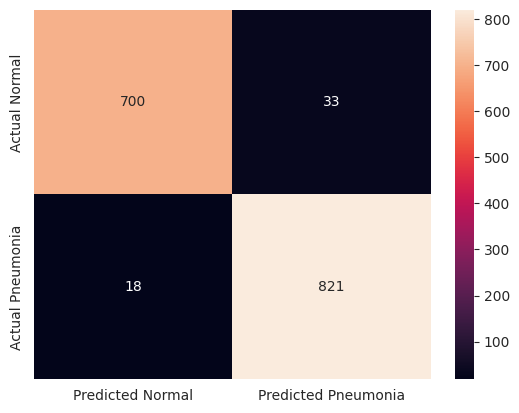

In [ ]:
test_generator.reset()

preds_8 = model_8.predict(test_generator,verbose=0)
preds_8 = preds_8.copy()
preds_8[preds_8 <= 0.5] = 0
preds_8[preds_8 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_8, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_8,target_names =['Normal','Pneumonia'], digits=4))

In [ ]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_final = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_final.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_final.add(BatchNormalization())
model_final.add(MaxPooling2D((2, 2)))

# Flatten layer
model_final.add(Flatten())
# 1nd Dense Layer
model_final.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_final.add(Dropout(0.5))
# 2nd Dense Layer
model_final.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_final.add(Dropout(0.3))
# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_final.add(Dense(1, activation='sigmoid'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_final.compile(optimizer=tf.keras.optimizers.RMSprop(),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])

# Summary of the Model Architecture
print(model_final.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_24 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 75, 75, 32)        16416     
                                                                 
 batch_normalization_25 (Ba  (None, 75, 75, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))
weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}


%time

# Fitting / training model
history_final = model_final.fit(train_generator,
                                epochs=50,
                                batch_size=32,
                                validation_data=validation_generator,
                                class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/50
158/158 [==============================] - 31s 188ms/step - loss: 0.7582 - accuracy: 0.8220 - val_loss: 5.0278 - val_accuracy: 0.5462
Epoch 2/50
158/158 [==============================] - 29s 183ms/step - loss: 0.2744 - accuracy: 0.9169 - val_loss: 2.6350 - val_accuracy: 0.5470
Epoch 3/50
158/158 [==============================] - 30s 191ms/step - loss: 0.2009 - accuracy: 0.9449 - val_loss: 4.6285 - val_accuracy: 0.5478
Epoch 4/50
158/158 [==============================] - 29s 186ms/step - loss: 0.1463 - accuracy: 0.9562 - val_loss: 5.5180 - val_accuracy: 0.5589
Epoch 5/50
158/158 [==============================] - 29s 184ms/step - loss: 0.1352 - accuracy: 0.9606 - val_loss: 0.1774 - val_accuracy: 0.9602
Epoch 6/50
158/158 [==============================] - 31s 196ms/step - loss: 0.1252 - accuracy: 0.9650 - val_loss: 0.1200 - val_accuracy: 0.9682
Epoch 7/50
158/158 [==============================] - 29s 186ms/st

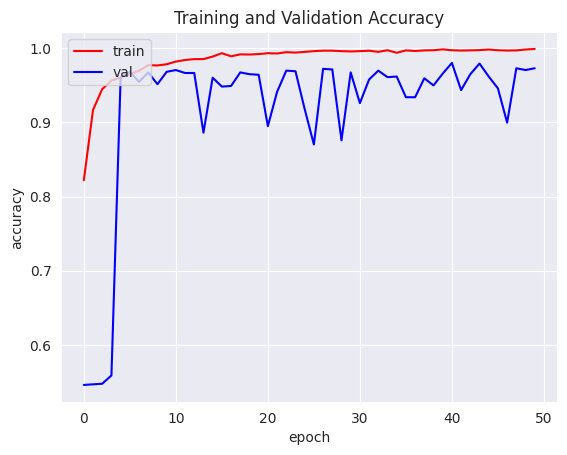

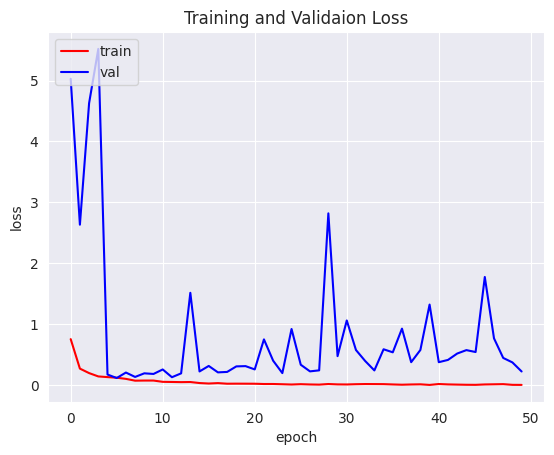

In [ ]:
acc = history_final.history['accuracy']
val_acc = history_final.history['val_accuracy']
loss = history_final.history['loss']
val_loss = history_final.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Normal     0.9767    0.9727    0.9747       733
   Pneumonia     0.9762    0.9797    0.9780       839

    accuracy                         0.9765      1572
   macro avg     0.9765    0.9762    0.9763      1572
weighted avg     0.9765    0.9765    0.9765      1572



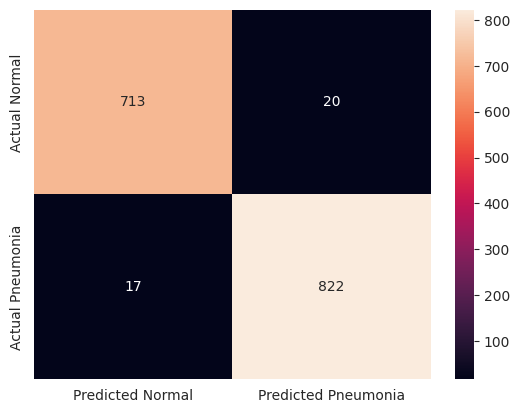

In [ ]:
test_generator.reset()

preds_final = model_final.predict(test_generator,verbose=0)
preds_final = preds_final.copy()
preds_final[preds_final <= 0.5] = 0
preds_final[preds_final > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_final, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_final,target_names =['Normal','Pneumonia'], digits=4))

In [ ]:
probabilities = model_5.predict(test_generator, 30)
for index, probability in enumerate(probabilities):
    image_path = TEST_DIR + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Pneumonia")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% Normal")
    plt.show()

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  test_img = image.load_img(fn, target_size=(150, 150),color_mode='grayscale')

  # Preprocessing gambar
  pp_test_img = image.img_to_array(test_img)
  pp_test_img = pp_test_img/255
  pp_test_img = np.expand_dims(pp_test_img, axis=0)

  # Prediksi menggunakan data baru
  test_preds= model_5.predict(pp_test_img)

  # Mencetak hasil prediksi
  plt.figure(figsize=(6,6))
  plt.axis('off')
  if test_preds >= 0.5:
      out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(test_preds[0][0]))

  else:
      out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-test_preds[0][0]))
  plt.title("Pneumonia Diseased Image Recognition\n"+out)
  plt.imshow(np.squeeze(pp_test_img))
  plt.show()